# Imports

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms # Image transform
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard
import matplotlib.pyplot as plt
import numpy as np

# Discriminator

In [70]:
class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(in_features, 128), # In features are the image dimensions
            nn.LeakyReLU(0.01), # Gradient of negative slope.
            nn.Linear(128, 1),
            nn.Sigmoid(), #Make sure output between [0, 1]
        )

    def forward(self, x):
        return self.disc(x)

# Generator

In [71]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256), # Z dimension is the noise vectir.
            nn.LeakyReLU(0.01),
            nn.Linear(256, img_dim),
            nn.Tanh(),  # normalize inputs to [-1, 1] so make outputs [-1, 1]
        )

    def forward(self, x):
        return self.gen(x)

# Hyperparameters

In [72]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("The device is", device)
lr = 3e-4
z_dim = 64
image_dim = 28 * 28 * 1  # 784
batch_size = 32
num_epochs = 100

The device is cuda


# Instantiate Model

In [73]:
disc = Discriminator(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device)
#Pipeline to transform image. Normalising -> image = (image - mean) / std
transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),]
) 

dataset = datasets.MNIST(root="dataset/", transform=transforms, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()
writer_fake = SummaryWriter(f"logs/fake")
writer_real = SummaryWriter(f"logs/real")
step = 0

In [74]:
for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.view(-1, 784).to(device) #Flatten everything
        batch_size = real.shape[0]

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)
        disc_real = disc(real).view(-1)
        # .ones_like creates matrix of 1's because they're all true.
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        # where the second option of maximizing doesn't suffer from
        # saturating gradients
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
                      Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1, 1, 28, 28)
                data = real.reshape(-1, 1, 28, 28)
                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                img_grid_real = torchvision.utils.make_grid(data, normalize=True)

                writer_fake.add_image(
                    "Mnist Fake Images", img_grid_fake, global_step=step
                )
                writer_real.add_image(
                    "Mnist Real Images", img_grid_real, global_step=step
                )
                step += 1

Epoch [0/100] Batch 0/1875                       Loss D: 0.7632, loss G: 0.6737
Epoch [1/100] Batch 0/1875                       Loss D: 0.3776, loss G: 1.2118
Epoch [2/100] Batch 0/1875                       Loss D: 0.6158, loss G: 0.9277
Epoch [3/100] Batch 0/1875                       Loss D: 0.8645, loss G: 0.6496
Epoch [4/100] Batch 0/1875                       Loss D: 0.4721, loss G: 1.5166
Epoch [5/100] Batch 0/1875                       Loss D: 0.5337, loss G: 1.3914
Epoch [6/100] Batch 0/1875                       Loss D: 0.2583, loss G: 1.9188
Epoch [7/100] Batch 0/1875                       Loss D: 0.5182, loss G: 1.1749
Epoch [8/100] Batch 0/1875                       Loss D: 0.5199, loss G: 1.0736
Epoch [9/100] Batch 0/1875                       Loss D: 0.3225, loss G: 1.9171
Epoch [10/100] Batch 0/1875                       Loss D: 0.5960, loss G: 1.3383
Epoch [11/100] Batch 0/1875                       Loss D: 0.6477, loss G: 1.2000
Epoch [12/100] Batch 0/1875           

# What are we producing?

In [75]:
# Untrained Model
un_gen = Generator(z_dim, image_dim).to(device)

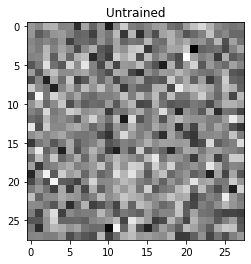

In [76]:
fixed_noise = torch.randn((batch_size, z_dim)).to(device)

bad_fake = un_gen(fixed_noise)

plt.title("Untrained")
plt.imshow(bad_fake[0].cpu().detach().numpy().reshape(28,28), cmap="gray")

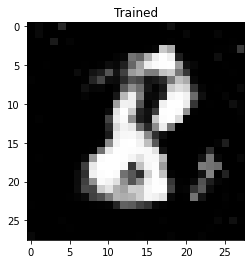

In [77]:
# Trained Model
fake = gen(fixed_noise)

plt.title("Trained")
plt.imshow(fake[0].cpu().detach().numpy().reshape(28,28), cmap="gray")